## Lab 5: Machine learning in Python

**Objectives:**
   * Engineer some features for better prediction of California house prices 
   * Train a machine learning model using <code>scikit-learn</code>
   * Evaluate our machine learning model

### Check for any updates in course materials

Before we start this assignment, we need to check whether there are any updates to the original course repository. We can do this by adding the original repository (the one we forked) as a *remote*. Command line users can do this by running:

<code>git fetch upstream</code>

<code>git merge upstream/master master</code>

GitHub Desktop users should first click the **Fetch origin** button to check for new changes. Then click the triangle symbol next to **Current branch: master**, click **Choose a branch to merge into master**, click **upstream/master** from **Other branches** and click **Create a merge commit**. 

Any new updates to the course repository will now be available in your local repository.

### Download the data for the lab

We will be using the California housing data which is available on Dropbox (see Slack or Canvas for link). Download `lab5/california_house_prices.csv` and `california_coastline.shp` to your local machine. 

A description of the dataset can be found [here](https://developers.google.com/machine-learning/crash-course/california-housing-data-description)

### Create a new environment and launch the notebook

As always, make a new environment that contains all the packages for this lab. Navigate to the `labs/lab5` folder (either from the terminal for Linux and Mac users or from the **CMD.exe Prompt** launched from **Anaconda Navigator** for Windows users) and run:

`conda env create -f environment.yml`

Activate this environment by running:

`conda activate lab5`

Now launch the lab demo notebook (if you haven't already): https://nbviewer.org/github/JohnnyRyan1/geospatial-data-science/blob/master/labs/lab5/lab5_demo.ipynb

Now we are ready to start...

## Feature engineering

The most important part of data science is generating new features that have predictive power. We just used the default variables for predicting house prices in the lecture but there are other factors that may be useful.

For example, we often have **geolocation data**, which could be very useful for house price prediction task. In this demo we will engineer some new features to improve the accuracy of our house price prediction model.

As a recap, these were the mean-sqaured-errors from the lecture demo:

* Multiple linear regression: $64,374


* Decision Tree: $82,290


* RandomForests: $60,264



In [1]:
# Import libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [4]:
# Import data
df = pd.read_csv('/home/johnny/Dropbox (University of Oregon)/Teaching/geospatial-data-science/data/lab5/california_house_prices.csv')

# Read dataset
coast = gpd.read_file('/home/johnny/Dropbox (University of Oregon)/Teaching/geospatial-data-science/data/lab5/california_coastline.shp')

In [5]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
gdf = gdf.set_crs(4326, allow_override=True)

# Reproject everything to UTM 10N (EPSG:32610)
gdf_utm = gdf.to_crs('EPSG:32610')
coast_utm = coast.to_crs('EPSG:32610')

In [6]:
# Compute distance to coast
distance_to_coast = []
for i in range(gdf_utm.shape[0]):
    distance_to_coast.append(coast_utm.distance(gdf_utm['geometry'].iloc[i]).min())
    
# Add to DataFrame
gdf_utm['distance_to_coast'] = distance_to_coast

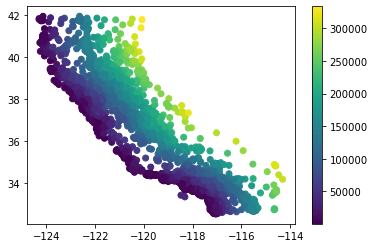

In [7]:
# Quickly check that it worked!
plt.scatter(gdf_utm['longitude'], gdf_utm['latitude'], c=gdf_utm['distance_to_coast'])
plt.colorbar()

## Correlation matrix

We will perform another correlation matrix to see if `distance_to_coast` is useful predictor of `median_house_value`.

In [8]:
# Compute correlation matrix
corr_matrix = gdf_utm.corr()

# Display just house value correlations
corr_matrix["median_house_value"].sort_values(ascending= False)

median_house_value    1.000000
median_income         0.668566
total_rooms           0.152923
households            0.098525
total_bedrooms        0.079023
population            0.020930
housing_median_age    0.014355
longitude            -0.020092
latitude             -0.173908
distance_to_coast    -0.505078
Name: median_house_value, dtype: float64

It is the second most correlated variable with `median_house_value`, excellent!

There are still some features that could be improved. For example, `total_rooms` and `total_bedrooms` does not mean much because it just depends on the number of house in the block group. A more useful metric would be **rooms per house** or **bedrooms per house**. 

We can add those columns pretty simply


In [9]:
# Rooms per house
gdf_utm['rooms_per_house'] = gdf_utm['total_rooms'] / gdf_utm['households']

# Bedrooms per house
gdf_utm['bedrooms_per_room'] = gdf_utm['total_bedrooms'] / gdf_utm['total_rooms']

In [10]:
# Compute correlation matrix
corr_matrix = gdf_utm.corr()

# Display just house value correlations
corr_matrix["median_house_value"].sort_values(ascending= False)

median_house_value    1.000000
median_income         0.668566
total_rooms           0.152923
rooms_per_house       0.113277
households            0.098525
total_bedrooms        0.079023
population            0.020930
housing_median_age    0.014355
longitude            -0.020092
latitude             -0.173908
bedrooms_per_room    -0.233964
distance_to_coast    -0.505078
Name: median_house_value, dtype: float64

The new `bedrooms_per_room` attribute is more correlated with `median_house_value` than the `total_rooms` or `total_bedrooms`. Apparently houses with a lower bedroom/room ratio tend to be more expensive. 

The `rooms_per_house` is surprisingly not that well correlated with `median_house_value`. Location is clearly the most important thing in the California housing market!

## Fit a model to data

In [11]:
# Define feature list
feature_list =  ['median_income', 'distance_to_coast', 'bedrooms_per_room', 
                 'total_rooms', 'rooms_per_house', 'total_bedrooms', 'households']

# Define features and labels 
X = gdf_utm[feature_list]
y = gdf_utm['median_house_value']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

In [12]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [13]:
# Define model
forest_reg = RandomForestRegressor(n_estimators = 30)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30)

## Evaluate model

In [14]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

56114.57594259003

So we improved our model by around $4,000. This might not sound like much but could make a big difference to someone and might the difference between winning a [Kaggle](https://www.kaggle.com/) competition or not.

## It's competition time!

In this week's lab we will play a Kaggle-like competition. In these competitions, a host usually prepares a dataset and people from around the world compete against each other to produce the best model. Submitted models are scored based on their predictive accuracy relative to a hidden solution file. 

We will be competing to produce the most accurate model for predicting house prices in Seattle. The dataset can be downloaded from the Dropbox link provided on Slack or Canvas. 

***********
## Question 1 (10 points): 

To start, make a **new** `jupyter notebook` called `lab5_submission.ipynb` and work through the following tasks. 

The first task is answer the following questions using some of the methods we have covered in the lecture/demo. 

* How many houses are in this dataset?
* How many **features** are there for predicting house price? 
* Are there any null values in this dataset?
* Which three variables are best correlated with house price (include correlation coefficients)?
* Which three variables are least correlated with house price (include correlation coefficients)?


*******

## Question 2 (30 points):

* Produce a model to predict house prices. You are welcome to generate new features, scale the data, and split the data into training/testing (i.e. `train_test_split`) in any way you like. 


* Evaluate your model's accuracy by predicting a test dataset, for example:

`predictions = forest_reg.predict(X_test)
final_mse = mean_squared_error(y_test, predictions)
final_rmse = np.sqrt(final_mse)`


* Push your `lab5_submission.ipynb` to GitHub and submit a `.pdf` version to Canvas 



* On **Monday** the instructor and TA will provide an **unseen set of houses** which students will use to repeat their accuracy evaluation. The best models (i.e. lowest RMSE) will win prizes. 


* We will evaluate the models using a simple `mean-squared-error` as follows:

`mse = mean_squared_error(y_test , predictions)
rmse = np.sqrt(final_mse)`

*********

## Task 1 (10 points):

Submit a project idea to the `#final-projects` channel on **Slack**. See: https://github.com/JohnnyRyan1/geospatial-data-science/blob/master/labs/lab5/project_ideas_task.md for more details.


## Remember to submit your answers to Questions 1 and 2 and complete Task 1 **by Friday 11:59pm**